# Data Processing

This notebook shows you how to obtain the dataset necessary for training a YOLO model for playing Fruit Ninja. After cloning the repository, the user will need to either source their own .mp4 videos of Fruit Ninja gameplay, or use the provided script to record their own gameplay for use in training data. The script can be found under `..\src\capture\recordgame.py` and works on any platform and is OS-independent. Instructions are provided within the script.
Run the script in a command line interface to create some raw videos. For example, from project root: `python src/capture/record_game.py --width 1280 --height 720 --output dataset/raw_videos/test_recording.mp4`

Once the raw gameplay videos are contained within `..\dataset\raw_videos`, the next processing step continues in this notebook.

### Extracting Frames from Raw Videos

In [1]:
import cv2
from pathlib import Path

# Configuration
PROJECT_ROOT = Path.cwd().parents[0]

RAW_VIDEOS_DIR = PROJECT_ROOT / "dataset" / "raw_videos"
RAW_FRAMES_DIR = PROJECT_ROOT / "dataset" / "raw_frames"

RAW_FRAMES_DIR.mkdir(parents=True, exist_ok=True)

skip = True

# Helpers
def delete_frames_for_video(video_name: str):
    """
    Remove all frames belonging to a given video.
    Frames are identified by prefix:  <video_stem>_
    Example:
       video 'example.mp4' removes files like 'example_01.jpg'
    """
    stem = video_name.rsplit(".", 1)[0]  # remove extension
    prefix = f"{stem}_"

    deleted = 0
    for f in RAW_FRAMES_DIR.glob(f"{prefix}*.jpg"):
        f.unlink()
        deleted += 1

    if deleted > 0:
        print(f"Removed {deleted} old frames for video: {video_name}")


def extract_frames(video_path: Path, fps: int = 10):
    """
    Extract frames from video at a fixed FPS and store all frames flatly in raw_frames/.
    Frames are named: <video_stem>_000000.jpg
    """
    video_name = video_path.name
    stem = video_name.rsplit(".", 1)[0]

    # Delete old frames belonging to this video
    delete_frames_for_video(video_name)

    cap = cv2.VideoCapture(str(video_path))
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    if original_fps == 0:
        raise ValueError(f"Unable to read FPS from video: {video_name}")

    frame_interval = int(original_fps / fps)
    frame_index = 0
    saved_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_index % frame_interval == 0:
            frame_name = f"{stem}_{saved_count:06d}.jpg"
            cv2.imwrite(str(RAW_FRAMES_DIR / frame_name), frame)
            saved_count += 1

        frame_index += 1

    cap.release()
    print(f"Processed {video_name}: {saved_count} frames written.")



# main
videos = sorted(RAW_VIDEOS_DIR.glob("*.mp4"))

if not videos and skip:
    print("No videos found. / Skipping.")
else:
    print(f"Found {len(videos)} video(s). Extracting frames...\n")

    for vid in videos:
        extract_frames(vid, fps=10)

    print("\nFrame extraction complete.")

Found 2 video(s). Extracting frames...

Removed 1027 old frames for video: fruitninja1.mp4
Processed fruitninja1.mp4: 1027 frames written.
Removed 689 old frames for video: fruitninja2.mp4
Processed fruitninja2.mp4: 689 frames written.

Frame extraction complete.


## Frame Visualization:

The below cell visualizes the frames generated by the above code.

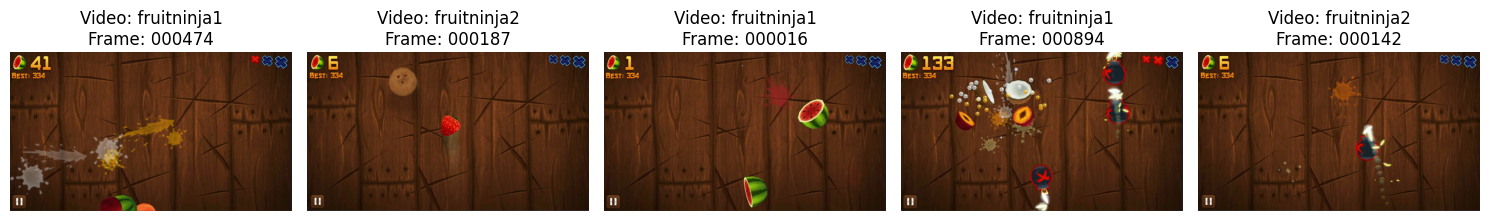

In [2]:
import matplotlib.pyplot as plt
import random

# Get list of all JPG frames
all_frames = sorted(RAW_FRAMES_DIR.glob("*.jpg"))

if len(all_frames) == 0:
    print("No frames found to visualize.")
else:
    # Pick 5 random frames
    samples = random.sample(all_frames, k=min(5, len(all_frames)))

    plt.figure(figsize=(15, 8))

    for i, frame_path in enumerate(samples, 1):
        # Extract metadata from filename: video_stem_frameindex.jpg
        # Example: "fruit_ninja_run1_000123.jpg"
        name = frame_path.stem  # no extension

        # Split into <video_stem> and <frame_index>
        # e.g. "fruit_ninja_run1_000123" -> ["fruit_ninja_run1", "000123"]
        try:
            video_stem, frame_idx = name.rsplit("_", 1)
        except ValueError:
            # fallback
            video_stem, frame_idx = name, "unknown"

        # Load image
        img = cv2.imread(str(frame_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot
        plt.subplot(1, 5, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Video: {video_stem}\nFrame: {frame_idx}")

    plt.tight_layout()
    plt.show()

Once you have your frames, use any tool to create a YOLO dataset. I personally used LabelStudio since it was open source and I could run it locally. I labeled about 900 images to start my model, however you could start off with about 500 images of 60% fruit, 30% bombs, and 10% empty, and train a model to help with the classification. I elected to manually label 900 images to ensure a high quality starting dataset. Once you have the labelled images complete, export the images into a YOLO-compatible dataset.

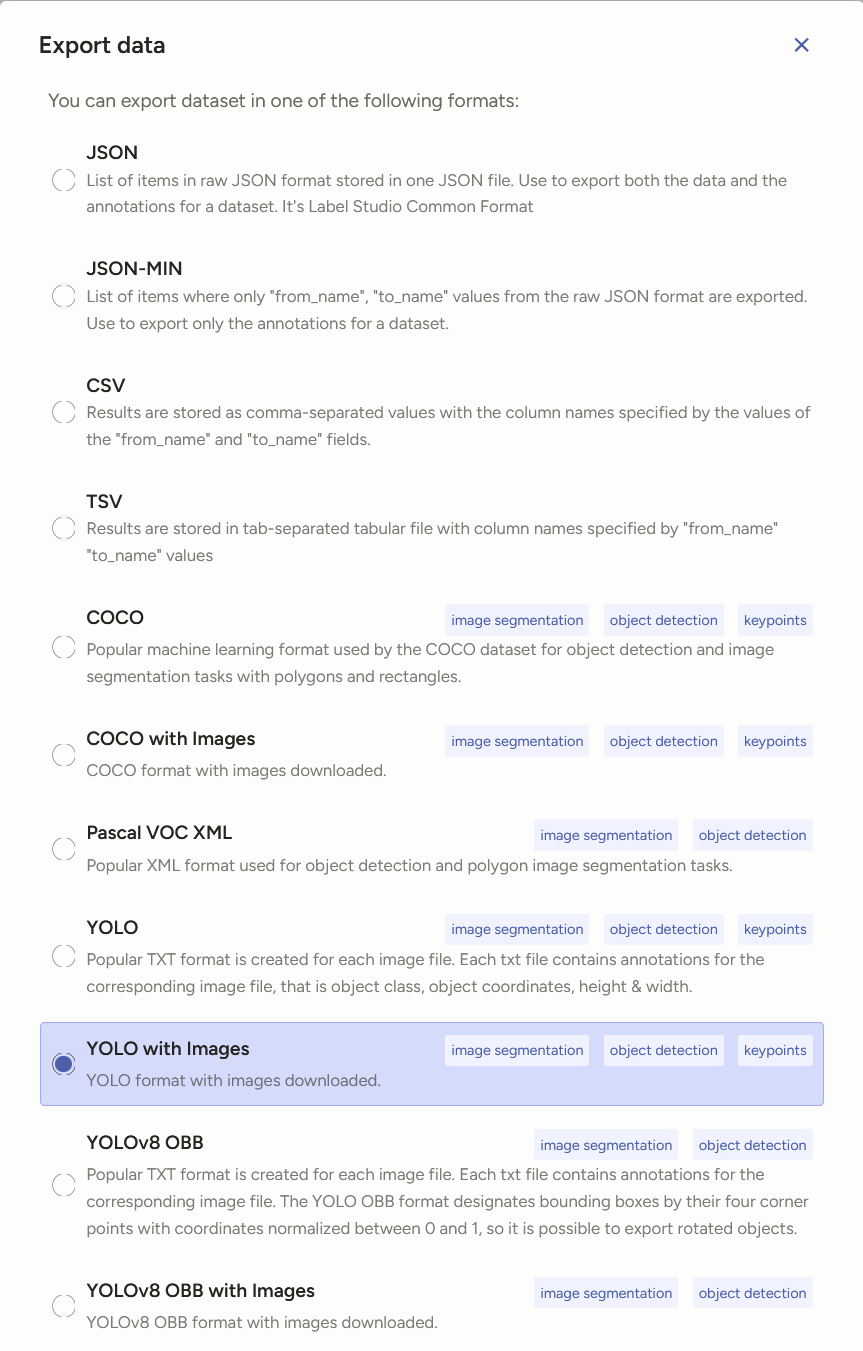

However, there were some limitations from using Label Studio. It actually runs on a Docker Container, so the images I had on my local computer needed to be mapped into a folder on the docker container. This creates issues when trying to save and export as "YOLO with Images". It does not export the images alongside the created labels. The .zip also does not contain a .yaml file, which is necessary for training a YOLO model. To remedy this issue, I wrote a custom script, `src/` to automatically match images with the associated .txt labels. Extract the .zip from Label Studio into `dataset/yolo`, then run the script to automatically map images from `dataset/raw_frames`. It will also generate the `.yaml` file in `dataset/yolo` and split it automatically into 80 train/20 val. For GitHub, the `dataset` directory will contain example images and data. Remove these prior to starting your own workflow.

In [4]:
import sys

SRC_PATH = PROJECT_ROOT / "src"

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

from data.build_yolo_dataset import main as build_yolo_dataset

build_yolo_dataset()

Building YOLO dataset with train/val split
Project root: .
Raw frames dir: dataset\raw_frames
Labels source dir: dataset\yolo\labels
Found 908 label files.

   classes
Valid pairs: 907
Train pairs: 725
Val pairs:   182

Copied files:
  Train images dir: dataset\yolo\images\train
  Val images dir:   dataset\yolo\images\val
  Train labels dir: dataset\yolo\labels\train
  Val labels dir:   dataset\yolo\labels\val

Loaded class names from dataset\yolo\classes.txt -> ['bomb', 'fruit']

Wrote YOLO config file: dataset\yolo\data.yaml

Done.


There should now be a complete dataset ready to use in `dataset/yolo`! Let's get to building the model.